# Figure S8: AMOC

This notebook will reproduce Figure S8 from the supplementary info of *Ocean Heat Content responses to changing Anthropogenic Aerosol Forcing Strength: regional and multi-decadal variability*, E. Boland et al. 2022 ([pre-print](https://doi.org/10.1002/essoar.10511062.1)). This will require utils.py (expects to find it in ../code) and input datafiles (expects to find them in ../data_in) to run - please see the README for details.

The data files loaded were created as follows:
- The AMOC at 45N was calculated as the depth-maximum of the Atlantic zonally intergrated meridional overturning circulation in calculate_AMOC.py, producing amoc\_45N\_\[exp\]\_\[run\].nc

Please attribute any plots or code from this notebook using the DOI from Zenodo: [10.5281/zenodo.6418479](https://doi.org/10.5281/zenodo.6418479)

E Boland Aug 2022 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'../code/')
import utils

In [2]:
# Directories for saving plots and finding input data
figs_dir = '../figs/' # Where you want the plots saved
data_dir='../data_in/' # Where the input data is (see README)

# Experiment info, don't alter
exps=['historical0p2','historical0p4','historical0p7','historical1p0','historical1p5']
exp_names=['0.2','0.4','0.7','1.0','1.5']
smurphs_cmap= [(255/255, 0 , 0),(255/255 ,165/255,   0),(190/255, 190/255, 190/255),(0   ,0 ,255/255),(160 /255, 32/255 ,240/255)]

In [3]:
amoc=[]
for exp in exps:
    amoc.append(xr.open_mfdataset(data_dir+'amoc_tseries/amoc_45N_'+exp+'*.nc',combine='nested',concat_dim=['run']))
amoc=xr.combine_nested(amoc,concat_dim='exp')

In [8]:
trend_startdates=['1960-01-16','1980-01-16']
trend_enddates=['1990-12-16','2010-12-16']
trend_middates=['1975-06-16','1995-06-16']
y_start=[1960,1980]
y_end=[1991,2011]

dplot=amoc['AMOC_strength'].sel(time_centered=slice('1850-01-01',None)).squeeze(drop=True)
dplot=dplot-dplot.sel(time_centered=slice('1850-01-01','1900-01-01')).mean(dim=['time_centered','run'])
tt=amoc.time_centered
tt_index=tt.dt.year+(tt.dt.dayofyear-1)/365.25
dplot['time_yr']=(('time_centered'),tt_index)

forc=xr.DataArray(coords={'exp':exps},data=[0.38,0.6,0.93,1.17,1.5],dims=['exp'],)

# Calculate 30y trends for two time periods
all_fit=[]
for tchunk in range(0,2):
    tslice=slice(trend_startdates[tchunk],trend_enddates[tchunk])
    xx=dplot['time_yr'].sel(time_centered=tslice)
    yy=dplot.sel(time_centered=tslice)
    lin_fit=utils.lin_regress(xx,yy,[["time_centered"], ["time_centered"]])
    lin_fit=lin_fit.assign_coords(time=trend_middates[tchunk])
    all_fit.append(lin_fit)
all_fit=xr.combine_nested(all_fit,concat_dim='time')
all_fit['forc']=forc

# Regress trends against forcing strength
trend_fit=[]
for tchunk in range(0,2):
    yy=all_fit.isel(time=tchunk).sel(parameter='slope')
    xx=forc.broadcast_like(yy) 
    lin_fit=xr.DataArray(utils.new_linregress(xx.stack(exp_run=('exp','run')).chunk({'exp_run': -1}),yy.stack(exp_run=('exp','run')).chunk({'exp_run': -1})),dims=['parameter'])
    lin_fit['parameter']=('parameter',["slope","intercept","r_value","p_value","std_err"])
    lin_fit=lin_fit.assign_coords(time=trend_middates[tchunk])
    trend_fit.append(lin_fit)
trend_fit=xr.combine_nested(trend_fit,concat_dim='time')

Text(0.5, 0.94, 'Ensemble mean AMOC at 45N relative to 1850-1900 mean')

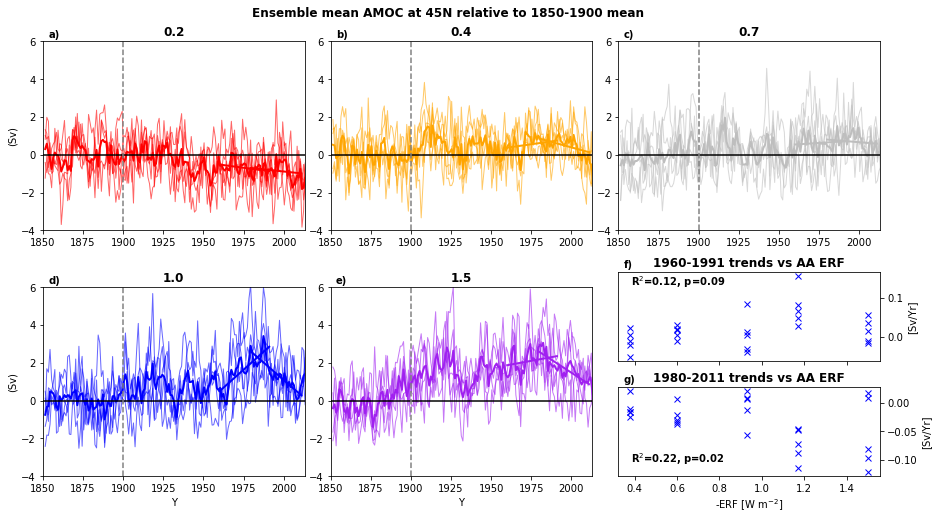

In [9]:
fig=plt.figure(figsize=[15,8])
cmap=smurphs_cmap
pp=[]
for ie,exp in enumerate(exps):
    ax=plt.subplot(2,3,ie+1)
    pp.append(dplot.sel(exp=exp).plot(x='time_yr',hue='run',color=cmap[ie],linewidth=1,add_legend=False,alpha=0.6)[0])
    dplot.mean(dim='run').sel(exp=exp).plot(x='time_yr',color=cmap[ie],linewidth=2,add_legend=False)
    # Plot linear trends
    for tchunk in range(0,2):
        xx=np.arange(y_start[tchunk],y_end[tchunk]+1)
        yy=all_fit.isel(time=tchunk,exp=ie).sel(parameter='slope').mean(dim='run').data*xx+all_fit.isel(time=tchunk,exp=ie).sel(parameter='intercept').mean(dim='run').data
        plt.plot(xx,yy,color=cmap[ie],linewidth=2)
    plt.axhline(0,color='k')
    plt.xlim([1850,2013])
    plt.axvline(1900,color='grey',ls='--')
    plt.ylim([-4,6])
    ax.text(0.02,1.02,'{})'.format(chr(ord('a')+ie)),fontweight='bold',transform=ax.transAxes)
    if np.mod(ie,3)==0:
        plt.ylabel('(Sv)')
    else:
        plt.ylabel('')
    if ie>2:
        plt.xlabel('Y')
    else:
        plt.xlabel('')
    plt.title(exp_names[ie],fontweight='bold')

for tchunk in range(0,2):   
    ax=plt.subplot(4,3,9+tchunk*3)
    p=all_fit.sel(parameter='slope').isel(time=tchunk).plot(x='forc',hue='run',marker='x',ls='',add_legend=False,color='b',ax=ax)
    ax.set_ylabel('[Sv/Yr]')    
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_title('{}-{} trends vs AA ERF'.format(y_start[tchunk],y_end[tchunk]),fontweight='bold')
    ax.text(0.05,0.85-0.7*tchunk,'R$^2$={:2.2f}, p={:2.2f}'.format(trend_fit.isel(time=tchunk).sel(parameter='r_value').data**2,
                                                      trend_fit.isel(time=tchunk).sel(parameter='p_value').data),
            transform=ax.transAxes,fontweight='bold',color='k')
    if tchunk==0:
        ax.set_xticklabels('')    
        ax.set_xlabel('')
    else:
        ax.set_xlabel('-ERF [W m$^{-2}$]')
    ax.text(0.02,1.05,'{})'.format(chr(ord('a')+5+tchunk)),fontweight='bold',transform=ax.transAxes)

plt.subplots_adjust(wspace=0.1,hspace=0.3)

plt.suptitle('Ensemble mean AMOC at 45N relative to 1850-1900 mean',fontweight='bold',y=0.94)
plt.savefig(figs_dir+'SIFig_AMOC45_byrun.png',bbox_inches='tight')